In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

# Print the installed solver to see if GUROBI is installed correctly
print("Current installed solvers: ", cp.installed_solvers())

Current installed solvers:  ['CLARABEL', 'ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [2]:
# Load the data
load_data = pd.read_csv('data/CAISO_Load_2022.csv', usecols=['net_load']).values.flatten()
thermal_gen_data = pd.read_csv('data/thermal_gen_offer.csv', usecols=['capacity_MW', 'energy_price'])

In [4]:
# Parameters
num_days = 365
num_steps = 288
num_intervals = 12
P = 10_000  # Total storage capacity in MW
E = 40_000  # Total storage capacity in MWh
eta = 0.9  # Storage one-way efficiency
C_s = 20.0  # Storage marginal discharge cost

# Generator data 
P_g = thermal_gen_data['capacity_MW'].values # Thermal generator capacities (MW)
C_g = thermal_gen_data['energy_price'].values # Thermal generator offer ($/MW)

# Reshape load data for num_days of num_steps
load = load_data[0:num_days*num_steps].reshape((num_days, num_steps)) # Net load profile

# Number of generators
num_gen = len(P_g)

In [5]:
# Function to solve the optimization problem for a single day
def solve_daily_optimization(L, P_g, C_g, P, E, eta, C_s, E0, num_intervals):
    # Variables
    p = cp.Variable((num_steps, num_gen))  # Power generation by each generator
    c = cp.Variable(num_steps)             # Power charge by storage
    d = cp.Variable(num_steps)             # Power discharge by storage
    e = cp.Variable(num_steps)             # State of Charge (SoC) of storage

    # Constraints
    constraints = []

    # Generator capacity constraints
    for g in range(num_gen):
        constraints += [p[:, g] >= 0,
                        p[:, g] <= P_g[g]]

    # Storage constraints
    constraints += [c >= 0,
                    c <= P,
                    d >= 0,
                    d <= P]

    # SoC constraints
    constraints += [e[0] == E0 + eta * c[0] - d[0] / eta]
    for t in range(1, num_steps):
        constraints += [e[t] == e[t-1] + eta * c[t] - d[t] / eta]
        
    constraints += [e >= 0, e <= E]

    # End of day SoC constraint
    constraints += [e[-1] == E / 2]  # End SoC is 50%

    # Balance constraints and capture dual variables
    balance_constraints = []
    for t in range(num_steps):
        balance_constraint = cp.sum(p[t, :]) + d[t] == L[t] + c[t]
        constraints += [balance_constraint]
        balance_constraints.append(balance_constraint)

    # Objective: Minimize system cost
    cost = (cp.sum(cp.multiply(p, C_g.reshape(1, -1))) + cp.sum(C_s * d))/ num_intervals
    objective = cp.Minimize(cost)

    # Problem definition
    problem = cp.Problem(objective, constraints)

    # Solve the problem using Gurobi if available, otherwise use a different solver
    start_time = time.time()
    try:
        problem.solve(solver=cp.GUROBI, verbose=False, reoptimize=True)
        dual_prices = [balance_constraint.dual_value * -num_intervals for balance_constraint in balance_constraints]  # Extract dual values
    except cp.SolverError:
        print("Gurobi not available. Falling back to a different solver.")
        problem.solve(solver=cp.ECOS, verbose=False)  # You can use ECOS, SCS, or another solve
        dual_prices = [balance_constraint.dual_value  * -num_intervals for balance_constraint in balance_constraints]  # Extract dual values
    end_time = time.time()
    end_time = time.time()

    return problem.value, p.value, c.value, d.value, e.value, dual_prices, end_time - start_time

# Solve for each day
results = []
E0 = E / 2  # Initial SoC is 50%

all_daily_costs = []
all_gen_output = []
all_storage_ops = []
all_clearing_prices= []

total_start_time = time.time()  # Start time for the entire solving loop

for day in range(num_days):
    L = load[day, :]
    daily_cost, daily_gen, daily_charge, daily_discharge, daily_soc, dual_prices, run_time = solve_daily_optimization(L, P_g, C_g, P, E, eta, C_s, E0, num_intervals)
    results.append((daily_cost, daily_gen, daily_charge, daily_discharge, daily_soc))
    print(f"Day {day + 1}: Cost = {daily_cost}, Run Time = {run_time} seconds")

    # Collect results for each day
    all_daily_costs.append({
        'day': day + 1,
        'cost': daily_cost,
        'run_time': run_time
    })

    all_gen_output.append(pd.DataFrame(daily_gen, columns=[f'gen_{i+1}' for i in range(num_gen)]))
    all_storage_ops.append(pd.DataFrame({
        'charge': daily_charge,
        'discharge': daily_discharge,
        'soc': daily_soc
    }))
    all_clearing_prices.append(pd.DataFrame({'clearing_price': dual_prices}))

total_end_time = time.time()  # End time for the entire solving loop
total_run_time = total_end_time - total_start_time

print(f"Total Run Time for all days: {total_run_time} seconds")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-23
Day 1: Cost = 15852525.427014893, Run Time = 1.3224289417266846 seconds
Day 2: Cost = 17993642.626535635, Run Time = 1.2549750804901123 seconds
Day 3: Cost = 19956311.47490785, Run Time = 1.255647897720337 seconds
Day 4: Cost = 17493649.112065397, Run Time = 1.1544058322906494 seconds
Day 5: Cost = 18879552.52554271, Run Time = 1.141753911972046 seconds
Day 6: Cost = 20672211.043984193, Run Time = 1.1399040222167969 seconds
Day 7: Cost = 17798021.584810883, Run Time = 1.1375939846038818 seconds
Day 8: Cost = 15510994.746976696, Run Time = 1.1288189888000488 seconds
Day 9: Cost = 16428500.756272888, Run Time = 1.1161139011383057 seconds
Day 10: Cost = 21778263.809978236, Run Time = 1.119373083114624 seconds
Day 11: Cost = 19834919.764962893, Run Time = 1.1213130950927734 seconds
Day 12: Cost = 21771624.809995264, Run Time = 1.1339528560638428 seconds
Day 13: Cost = 22882070.30416313, Run Time = 1.

In [7]:
# Save all results to CSV
# Daily costs
pd.DataFrame(all_daily_costs).to_csv('results/daily_costs.csv', index=False)

# Generator outputs
all_gen_output_df = pd.concat(all_gen_output, keys=range(1, num_days+1), names=['day', 'step'])
all_gen_output_df.to_csv('results/generator_outputs.csv')

# Storage operations
all_storage_ops_df = pd.concat(all_storage_ops, keys=range(1, num_days+1), names=['day', 'step'])
all_storage_ops_df.to_csv('results/storage_operations.csv')

# Clearing prices
all_clearing_prices_df = pd.concat(all_clearing_prices, keys=range(1, num_days+1), names=['day', 'step'])
all_clearing_prices_df.to_csv('results/clearing_prices.csv')

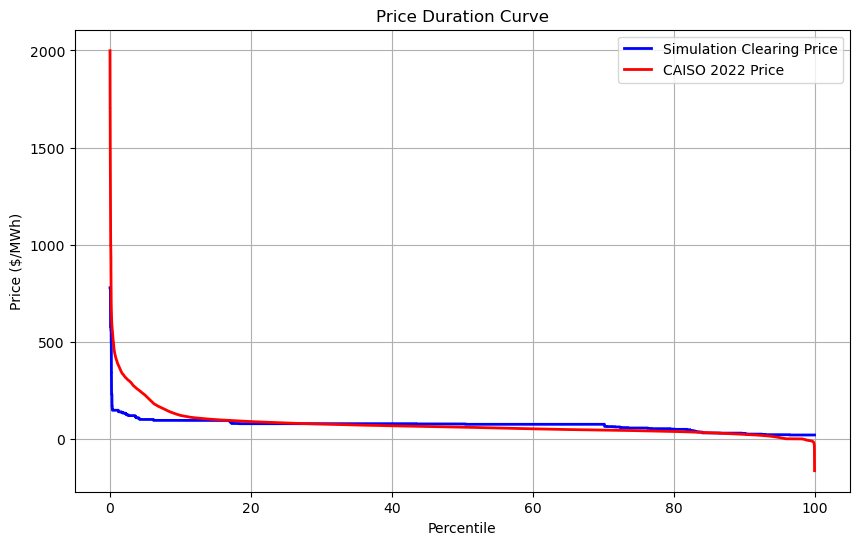

In [8]:
# Load the clearing prices data and historial energy price
clearing_prices_df = pd.read_csv('results/clearing_prices.csv')
energy_prices_df = pd.read_csv('data/CAISO_RTP_2022.csv', usecols=['energy'])

# Flatten the clearing prices into a single array
clearing_prices = clearing_prices_df['clearing_price'].values[0:104832]

# Flatten the energy prices into a single array
energy_prices = energy_prices_df['energy'].values

# Sort the clearing prices and energy prices in descending order
sorted_clearing_prices = np.sort(clearing_prices)[::-1]
sorted_energy_prices = np.sort(energy_prices)[::-1]

# Calculate the percentage rank for each price
percentiles = np.linspace(0, 100, len(sorted_clearing_prices))

# Plot the price duration curves
plt.figure(figsize=(10, 6))
plt.plot(percentiles, sorted_clearing_prices, color='blue', linewidth=2, label='Simulation Clearing Price')
plt.plot(percentiles, sorted_energy_prices[:len(percentiles)], color='red', linewidth=2, label='CAISO 2022 Price')
plt.xlabel('Percentile')
plt.ylabel('Price ($/MWh)')
plt.title('Price Duration Curve')
# plt.xlim([0,0.1])
# plt.ylim([0,2000])
plt.legend()
plt.grid(True)
plt.show()

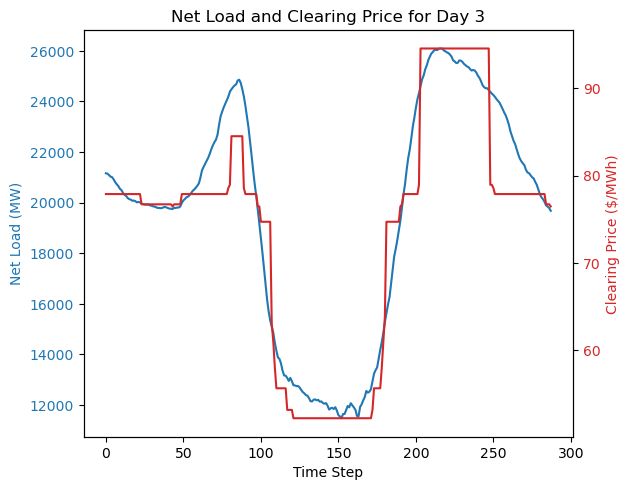

In [15]:
# Load the data
load_data = pd.read_csv('data/CAISO_Load_2022.csv', usecols=['net_load']).values.flatten()[0:2016]
clearing_prices_df = pd.read_csv('results/clearing_prices.csv')[0:2016]

# Reshape load data for 365 days of 288 steps
num_days = 7
num_steps = 288
L = load_data.reshape((num_days, num_steps))

# Extract the clearing prices
clearing_prices = clearing_prices_df['clearing_price'].values.reshape((num_days, num_steps))

# Plot net load and clearing price for a selected day
selected_day = 2  # Change this to select a different day (0 for the first day)

net_load = L[selected_day, :]
clearing_price = clearing_prices[selected_day, :]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Net Load (MW)', color=color)
ax1.plot(net_load, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Clearing Price ($/MWh)', color=color)
ax2.plot(clearing_price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Net Load and Clearing Price for Day {selected_day + 1}')
plt.show()